In [36]:
import scanpy as sc
import graph_tool.all as gt
import schist
import scipy.stats
import seaborn as sns
import sklearn.metrics
import pickle
import pandas as pd
import anndata
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [34]:
adata=schist.io.read('../scRNA_paga/state_adata/Quartzseq_minimize_weighted')

In [39]:
adata=schist.io.read('../scRNA_paga/state_adata/Quartzseq_minimize')

# Group strenght
Beside the differential gene expression analysis, we tried to use informations coming from cell-affinities also to evaluate the strenght of a group: selecting only cells with high affinity will reduce the total number of cells, however some groups are more stable than others; this should imply that if the clustering algorithm have identified a group but many cells within the group have a low affinity measure, the group could be not significative or less significative than other groups.

In [4]:
adata=adata_w.copy()

Trying to set attribute `.uns` of view, copying.


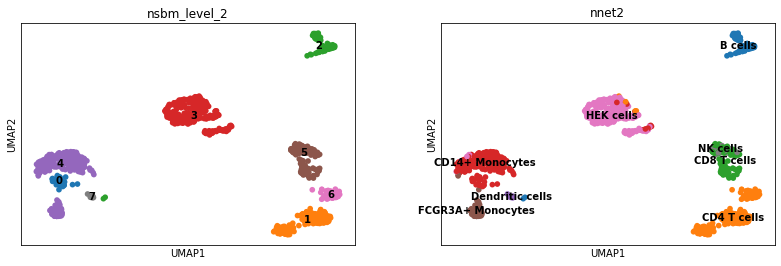

In [17]:
M=adata.uns['nsbm']['cell_affinity']['2']
adata.obs['max_u'] = 1 - np.max(M, axis=1) 
sc.pl.umap(adata[adata.obs.max_u < 1e-100], color=['nsbm_level_2','nnet2'],legend_loc='on data')

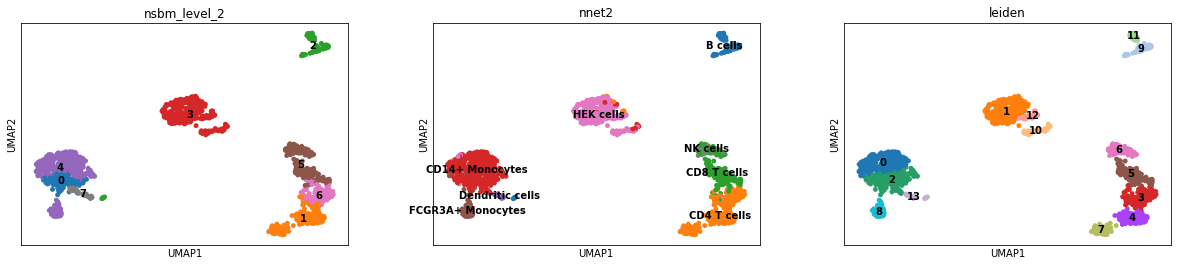

In [18]:
sc.pl.umap(adata, color=['nsbm_level_2','nnet2','leiden'],legend_loc='on data')

### Groups size
One of the first osbervation we made is that increasing the threshold of selection, the size of some groups drops down,while other groups are really stable. Therefore, we reppresented the profile of the size of each group when threshold increases

In [9]:
adata=adata_w

level = '2'
marginals = adata.uns['nsbm']['cell_affinity'][level] 
group_names = adata.obs[f'nsbm_level_{level}'].cat.categories
Max = marginals[marginals < 1].max()
Min = marginals[marginals > 0].min()
thr = np.linspace(Min, Max, 10)
thr = np.array([ 10**-x for x in range(0, 11)])

In [10]:
n_cell = adata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
cell_aff = np.max(marginals, axis=1)

D = np.array([adata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])

p = D / n_cell
p = p.T

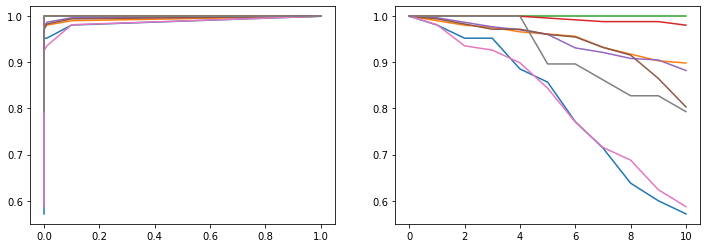

In [11]:
figure(figsize=(12, 4))
subplot(1,2,1)
for x in p:
    plot( thr,x)
subplot(1,2,2)
for x in p:
    plot( x)

Groups 2 and 3 mantain almost 100% of cells even at the highest threshold, therefore it reppresents a very strogn group. On the other hand, groups as 0 and 6 reduce their population by almost the half

 The Mutual Information score increases when we use higher threshold both for leiden and nSBM reppresentation, so cell affinity measure has a functional significance.

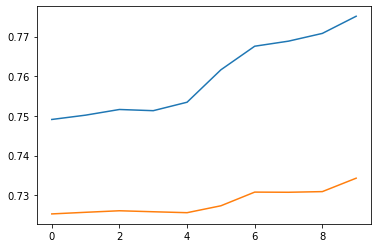

In [14]:
import sklearn
thr = np.array([ 10**-x for x in range(0, 10)])
mi_nsbm=list()
mi_leiden=list()
for i in thr:
    subdata=adata[adata.obs.max_u < i]
    mi_nsbm.append(sklearn.metrics.adjusted_mutual_info_score(subdata.obs.nsbm_level_2, subdata.obs.nnet2))
    mi_leiden.append(sklearn.metrics.adjusted_mutual_info_score(subdata.obs.leiden, subdata.obs.nnet2))
plot(mi_nsbm)
plot(mi_leiden)

### Uncertainty Areas

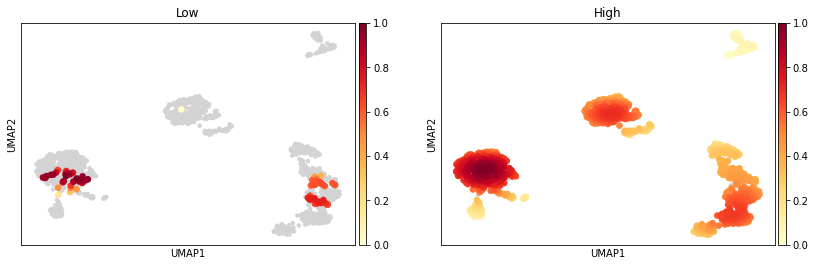

In [16]:
fdata=adata_w
level=str(2)
marginals = fdata.uns['nsbm']['cell_affinity'][level] 
d = pd.Categorical(np.max(marginals, axis=1) > (1 - 1e-5))
d.rename_categories(['Low', 'High'], inplace=True)
fdata.obs['max_A'] = d
sc.tl.embedding_density(fdata, groupby='max_A', key_added='dense_1')
sc.pl.embedding_density(fdata, key='dense_1')

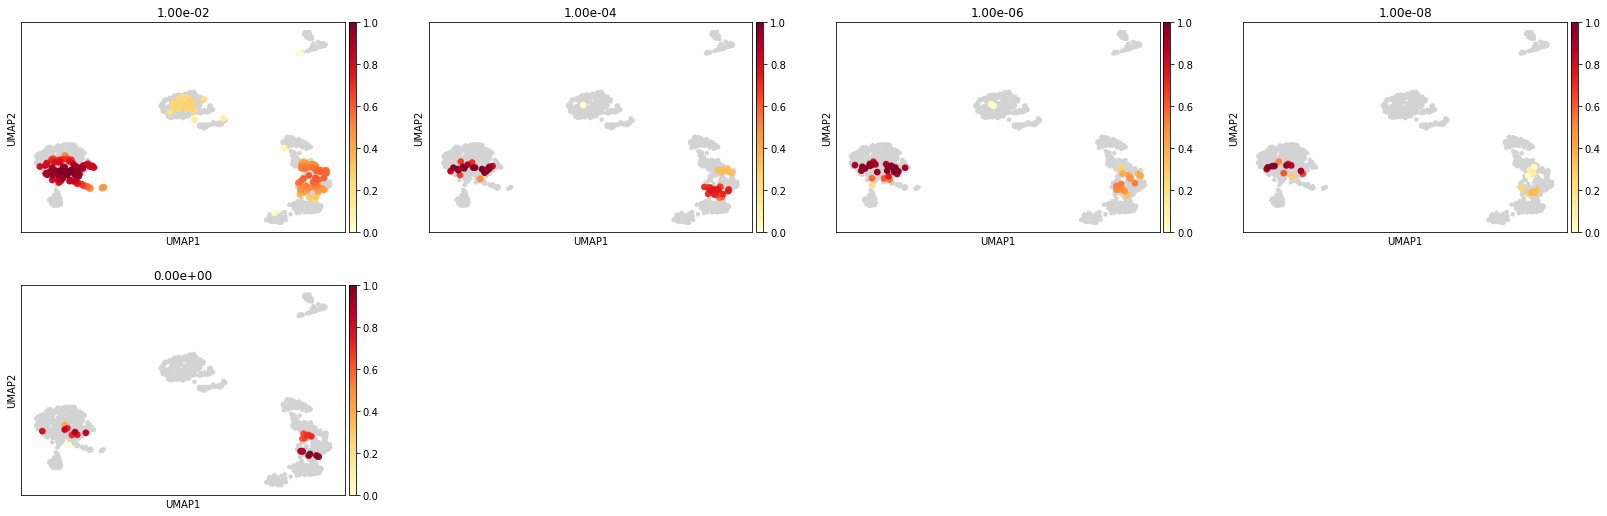

In [17]:
cuts = [0]+ [10**-x for x in range(0, 10, 2)][::-1]
d = pd.Categorical(pd.cut(1-np.max(marginals, axis=1), cuts))
d.rename_categories([f'{x:.2e}' for x in cuts[:-1]][::-1], inplace=True)
fdata.obs['max_A'] = d
sc.tl.embedding_density(fdata, groupby='max_A', key_added='dense_1')
sc.pl.embedding_density(fdata, key='dense_1')

# Reppresentation of strongest groups
The reppresentation of the strongest group is based upon 2 threshold:



1) The first threshold indicates the affinity measure above which we select cells


2) The second threshold indicates how many cells in the same group possess an affinity measure that outmatch the firts threshold

<ipython-input-27-b8faf31145be>:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values


1
2
3
4
5
6
7
8
9
10
11
12


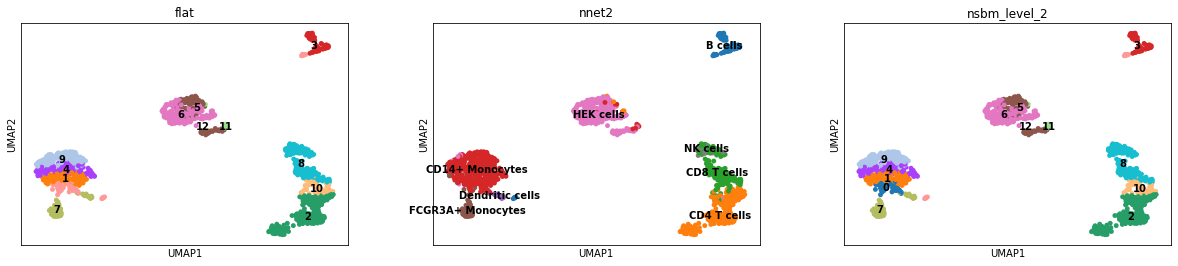

[0.05128205128205128, 0.028846153846153848, 0.01444043321299639, 0.0, 0.04040404040404041, 0.024390243902439025, 0.006024096385542169, 0.014084507042253521, 0.005780346820809248, 0.031496062992125984, 0.0, 0.0, 0.0]


In [27]:
level=str(2)
marginals = adata.uns['nsbm']['cell_affinity'][level] 
adata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
#adata.obs['max_P'] = np.max(marginals,axis=1)
group_sig=[]
group_names = adata.obs[f'nsbm_level_{level}'].cat.categories
for group in group_names:
    adata0=adata[adata.obs[f'nsbm_level_{level}']==group]
    c=0
    for i in adata0.obs['max_P']:
        if i>0.05:
#        if i>0.95:
            c=c+1
    c=c/(len(adata0.obs['max_P']))
    group_sig.append(c)
cdata=adata
flat=pd.Series()
for i in range(len(group_sig)):
    if group_sig[i]<0.05:
#    if group_sig[i]>0.95:
        a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==str(i)], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==str(i)])
        flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
        print(i)
cdata.obs['flat']=flat
sc.pl.umap(cdata, color=['flat','nnet2',f'nsbm_level_{level}'],legend_loc='on data')
print(group_sig)

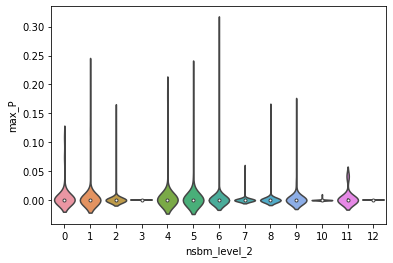

In [28]:
sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = adata.obs, scale='width')

In [31]:
M=adata.uns['nsbm']['cell_affinity']['2']
adata.obs['max_u'] = 1 - np.max(M, axis=1)
sort_w=adata[adata.obs.max_u<1e-10]
sort_w.n_obs*len(adata.obs.nsbm_level_2.cat.categories)

8584

In [33]:
M=adata.uns['nsbm']['cell_affinity']['2']
adata.obs['max_u'] = 1 - np.max(M, axis=1)
sort_unw=adata[adata.obs.max_u<1e-10]
sort_unw.n_obs*len(adata.obs.nsbm_level_2.cat.categories)

10738

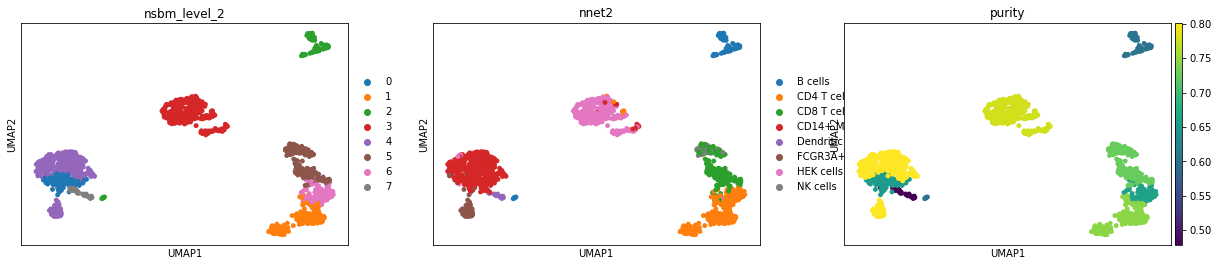

In [38]:
level=2
entro=scipy.stats.entropy(adata.uns['nsbm']['cell_affinity'][f'{level}'], axis=0)/ np.log(adata.shape[0])
purity= []
for i in adata.obs[f'nsbm_level_{level}']:
    purity.append(entro[int(i)])
adata.obs['purity']=purity
sc.pl.umap(adata,color=[f'nsbm_level_{level}','nnet2','purity'])

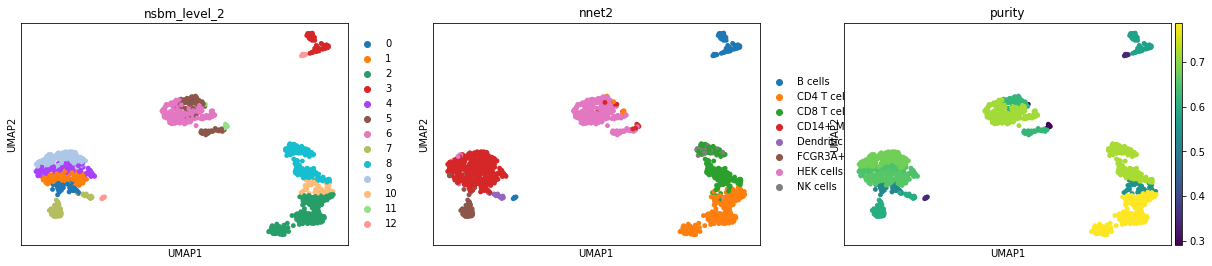

In [41]:
level=2
entro=scipy.stats.entropy(adata.uns['nsbm']['cell_affinity'][f'{level}'], axis=0)/ np.log(adata.shape[0])
purity= []
for i in adata.obs[f'nsbm_level_{level}']:
    purity.append(entro[int(i)])
adata.obs['purity']=purity
sc.pl.umap(adata,color=[f'nsbm_level_{level}','nnet2','purity'])